In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
from sklearn.model_selection import cross_val_score , train_test_split
from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('cleaned_data.csv')
df.head()

,area_type,availability,location,society,total_sqft,bath,balcony,price,house_size,house_type
0,Super built-up Area,19-Dec,Electronic City Phase II,coomee,1056.0,2,1,39.07,2,0
1,Plot Area,Ready To Move,Chikka Tirupathi,theanmp,2600.0,5,3,120.00,4,1
2,Built-up Area,Ready To Move,Uttarahalli,independent,1440.0,2,3,62.00,3,0
3,Super built-up Area,Ready To Move,Lingadheeranahalli,soiewre,1521.0,3,1,95.00,3,0
4,Super built-up Area,Ready To Move,Kothanur,independent,1200.0,2,1,51.00,2,0


### availability

- After checking different methods i come to a conclusion to simplify the process

**Converting availability column**
- 1 if house is Ready to move
- 0 if it is availabe in future

In [3]:
df['availability'] = df['availability'].apply(lambda x: 1 if x == 'Ready To Move' else 0)

In [4]:
df.head()

,area_type,availability,location,society,total_sqft,bath,balcony,price,house_size,house_type
0,Super built-up Area,0,Electronic City Phase II,coomee,1056.0,2,1,39.07,2,0
1,Plot Area,1,Chikka Tirupathi,theanmp,2600.0,5,3,120.00,4,1
2,Built-up Area,1,Uttarahalli,independent,1440.0,2,3,62.00,3,0
3,Super built-up Area,1,Lingadheeranahalli,soiewre,1521.0,3,1,95.00,3,0
4,Super built-up Area,1,Kothanur,independent,1200.0,2,1,51.00,2,0


### Ordinal Encode - area_type

- (Tried : OHE , LabelEncoding,Target Encoding) 
- On checking correlation of the column after each encoding, Ordinal Encoding is providing the best results.

In [5]:
# ordinal mapping
ordinal_mapping = {
    'Super built-up  Area': 4,
    'Built-up  Area': 3,
    'Plot  Area': 2,
    'Carpet  Area': 1
}

# instance of the OrdinalEncoder with the defined mapping
ordinal_encoder = OrdinalEncoder(categories=[sorted(ordinal_mapping, key=ordinal_mapping.get, reverse=True)])

# Apply ordinal encoding to the area_type column
df['area_type'] = ordinal_encoder.fit_transform(df[['area_type']])


### Target Encode - 'society' , 'location'

- Using target encoder as these columns does not contain any inherent order and have 80 different dates. 

In [6]:
# Target Encoder : replace categories with the mean of the target variable for each category

encoder = ce.TargetEncoder(cols=['society', 'location'])

# Fit and transform the data
df_encoded = encoder.fit_transform(df, df['price'])

# Replace the original columns with the encoded ones
df[['society', 'location']] = df_encoded[['society', 'location']]

In [7]:
df.head()

,area_type,availability,location,society,total_sqft,bath,balcony,price,house_size,house_type
0,0.0,0,47.021069,87.018319,1056.0,2,1,39.07,2,0
1,2.0,1,101.194847,101.583172,2600.0,5,3,120.00,4,1
2,1.0,1,61.665593,100.963959,1440.0,2,3,62.00,3,0
3,0.0,1,106.445528,106.781414,1521.0,3,1,95.00,3,0
4,0.0,1,87.743567,100.963959,1200.0,2,1,51.00,2,0


## Checking Feature importance

In [8]:
# changing price column position for better interpretability in heatmap

price_column = df.pop('price')  
df.insert(0, 'price', price_column)

### Technique 1

In [9]:
# checkin feature importance
fi_df1 = df.corr()['price'].iloc[1:].to_frame().reset_index().rename(columns={'index':'feature','price':'corr_coeff'})
fi_df1

,feature,corr_coeff
0,area_type,0.260267
1,availability,0.078636
2,location,0.513361
3,society,0.522799
4,total_sqft,0.727278
5,bath,0.622468
6,balcony,0.066440
7,house_size,0.557690
8,house_type,0.337047


In [10]:
# Splitting the dataset into training and testing sets
X = df.drop('price', axis=1)
y = df['price']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

### Technique 2 - by random forest

In [12]:
# Train a Random Forest regressor on label encoded data
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Extract feature importance scores for label encoded data
fi_df2 = pd.DataFrame({
    'feature': X_train.columns,
    'rf_importance': rf.feature_importances_
}).sort_values(by='rf_importance', ascending=False)

fi_df2

,feature,rf_importance
4,total_sqft,0.559914
2,location,0.174502
5,bath,0.108634
3,society,0.083417
0,area_type,0.025623
6,balcony,0.016763
7,house_size,0.013594
8,house_type,0.013313
1,availability,0.004240


### Technique 3 - Gradient Boosting

In [13]:
# Train a Random Forest regressor on encoded data
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

# Extract feature importance scores for label encoded data
fi_df3 = pd.DataFrame({
    'feature': X_train.columns,
    'gb_importance': gb.feature_importances_
}).sort_values(by='gb_importance', ascending=False)

fi_df3

,feature,gb_importance
4,total_sqft,0.619159
2,location,0.156201
5,bath,0.082847
3,society,0.076734
0,area_type,0.030219
8,house_type,0.017092
7,house_size,0.015202
1,availability,0.001563
6,balcony,0.000982


### Technique 4 - Permutation Importance

In [14]:
# Train a Random Forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Calculate Permutation Importance
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42)

# Organize results into a DataFrame
fi_df4 = pd.DataFrame({
    'feature': X_train.columns,
    'permutation_importance': perm_importance.importances_mean
}).sort_values(by='permutation_importance', ascending=False)

fi_df4

,feature,permutation_importance
4,total_sqft,0.408945
2,location,0.234557
3,society,0.159893
0,area_type,0.062640
5,bath,0.058254
8,house_type,0.040481
6,balcony,0.010870
7,house_size,0.005645
1,availability,0.001561


In [15]:
final_fi_df = fi_df1.merge(fi_df2,on='feature').merge(fi_df3,on='feature').merge(fi_df4,on='feature').set_index('feature')

In [16]:
# normalize the score
final_fi_df = final_fi_df.divide(final_fi_df.sum(axis=0), axis=1)
final_fi_df[['rf_importance','gb_importance','permutation_importance']].mean(axis=1).sort_values(ascending=False)

feature
total_sqft      0.531718
location        0.189785
society         0.107611
bath            0.083584
area_type       0.039859
house_type      0.023864
house_size      0.011513
balcony         0.009602
availability    0.002464
dtype: float64

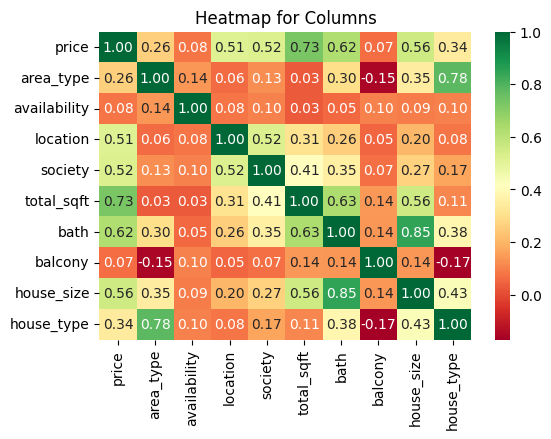

In [17]:
# Heatmap 
def create_heatmap(data):
    plt.figure(figsize=(6,4))
    sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='RdYlGn')
    plt.title('Heatmap for Columns')
    plt.show()

create_heatmap(df)

# Observation

- total_sqft , bath, house_size, society & location are most important features.

- availability & balcony are least contributing factor.

In [18]:
# with all the cols
rf = RandomForestRegressor(n_estimators=100, random_state=42)

scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')

In [19]:
scores.mean()

0.8303394371689633

In [20]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

scores = cross_val_score(rf, X_train.drop(columns=['availability', 'balcony']), y_train, cv=5, scoring='r2')

In [21]:
scores.mean()

0.827295363862387

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12106 entries, 0 to 12105
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         12106 non-null  float64
 1   area_type     12106 non-null  float64
 2   availability  12106 non-null  int64  
 3   location      12106 non-null  float64
 4   society       12106 non-null  float64
 5   total_sqft    12106 non-null  float64
 6   bath          12106 non-null  int64  
 7   balcony       12106 non-null  int64  
 8   house_size    12106 non-null  int64  
 9   house_type    12106 non-null  int64  
dtypes: float64(5), int64(5)
memory usage: 945.9 KB


**Deciding not to drop the columns**

In [23]:
df.to_csv('cleaned_feature_selection.csv', index=False)